In [1]:
from CharRNN import CharRNN
import pandas as pd
import tensorflow as tf
from utils import *
from tqdm import trange
from rdkit import Chem
from rdkit.Chem import Draw
from chembl_webresource_client.new_client import new_client
from IPython.display import clear_output
import editdistance
from sklearn.manifold import TSNE
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
%matplotlib inline

Using TensorFlow backend.


In [2]:
rnn_cell_size = 64
num_layers = 2
embedding_size = 32

split_size = 30
batchsize = 100
epochs = 100
stride=1

num_features = 3

In [3]:
sess = tf.Session()

In [4]:
model = CharRNN(sess, len(elems)+num_features, len(elems), embedding_size, 
                rnn_cell_size, num_layers, len(elems)-1,sess_chkpt='final.chkpt')

INFO:tensorflow:Restoring parameters from final.chkpt


In [5]:
def get_bondings(target_chembl, max_num=1000):

    target = new_client.target
    activity = new_client.activity
    molecule = new_client.molecule

    activity = activity.filter(target_chembl_id=target_chembl).filter(standard_type="IC50")

    molecules = []
    
    for i in trange(len(activity)):
        
        try:
            act = activity[i]
        except:
            print("We fucked up: ", i)
        
        if len(molecules) >= max_num:
            break
            
        id = act['molecule_chembl_id']
        molec = molecule.get(id)
        
        if (act['standard_value'] is not None and 
            molec['molecule_properties']['acd_logd'] is not None and
            molec['molecule_properties']['acd_logp'] is not None):
            
            molecules.append({
                'canonical_smiles': molec['molecule_structures']['canonical_smiles'],
                'acd_logd': float(molec['molecule_properties']['acd_logd']),
                'acd_logp': float(molec['molecule_properties']['acd_logp']),
                'affinity': float(act['standard_value'])

            })
    return molecules

In [6]:
target_list = ['CHEMBL240', 'CHEMBL3563', 'CHEMBL226']

In [7]:
bondings = list(map(lambda x: get_bondings(x, max_num=np.inf), target_list))

  3%|▎         | 273/9859 [01:14<43:53,  3.64it/s] KeyboardInterrupt
Sat Nov  4 05:04:29 2017


KeyboardInterrupt: 

In [7]:
from sklearn.externals import joblib

In [100]:
joblib.dump(bondings, 'bondings.jl')

['bondings.jl']

In [8]:
full_bondings = joblib.load('bondings.jl')

# More training

In [9]:
def retrain_iterate_minibatches(new_data, old_data, new_features_full, old_features_full, batch_size, 
                                extra_loss, shuffle=True):
    
    if shuffle:
        indices = np.arange(len(new_data))
        np.random.shuffle(indices)
    
    for start_idx in range(0, len(new_data) - batch_size + 1, batch_size):
        
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        
        new_X = new_data[excerpt]
        new_features = new_features_full[excerpt]
        
        old_X_ind = np.random.choice(np.arange(len(old_data)), size=batch_size)
        old_X = old_data[old_X_ind]
        old_features = old_features_full[old_X_ind]
        
        losses = [extra_loss for _ in range(len(new_X))] + [0.5 for _ in range(len(old_X))]
        
        seqs = np.concatenate([new_X, old_X])
        
        lengths = list(map(lambda x: len(x)-1, seqs))
        
        seqs = pad_sequences(seqs, padding='post')
        
        features = np.concatenate([new_features, old_features])
        
        X, Y = zip(*map(lambda x: prepare_seq(x[0], x[1]), zip(*[seqs, features])))
        
        yield np.array(X), np.array(Y), np.array(lengths), np.array(losses)
        

In [10]:
bondings = full_bondings[0]

In [11]:
old = pd.read_csv('chembl.csv')

old = old[~pd.isnull(old.acd_logd) & ~pd.isnull(old.acd_logp)]
old['affinity'] = np.zeros(old.shape[0])

old_smiles = old.canonical_smiles.apply(norm).values
old_features = old[["acd_logd", "acd_logp", "affinity"]].values

new_smiles = np.array(list(map(norm, [x['canonical_smiles']for x in bondings])))
new_features = np.array([[x["acd_logd"], x["acd_logp"], x["affinity"]] for x in bondings])

/data/home/viktor_petukhov/local/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
new_features[:, 2] = np.log1p(new_features[:, 2])

In [13]:
indicies = np.arange(len(new_features))

np.random.shuffle(indicies)

train_idx = 0.8 * len(new_features)

train_smiles, test_smiles = np.split(new_smiles, [train_idx])
train_features, test_features = np.split(new_features, [train_idx])

/data/home/viktor_petukhov/local/anaconda3/lib/python3.5/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


In [14]:
def concat_vecs(smile, features):
    return np.array([features.tolist()+to_categorical(x, len(elems))[0].tolist() for x in smile])

def prepare_for_nn(smile, features):
    x, y = prepare_seq(smile, features)
    
    length = len(x)
    
    return x, y, length

def measure_losses(smile, true_features, possible_affinities):
    
    x, y, length = prepare_for_nn(smile, true_features)
    
    feat = true_features.copy()
    
    true_loss = model.count_loss([x], [y], [length])
    
    losses = []
    
    for aff in possible_affinities:
        feat[-1] = aff
        
        x, y, length = prepare_for_nn(smile, feat)
        
        loss = model.count_loss([x], [y], [length])
        
        losses.append(loss)
        
    return true_loss, losses

In [15]:
def draw_affinity_graph(affinity, losses, true_affinity):
    plt.plot(affinity, losses)
    plt.axvline(x=true_affinity)

In [16]:
batchsize = 100
extra_loss = 3

In [17]:
validation_losses=[]
global_trues = []
averages = []

In [21]:
full_indicies = np.random.choice(np.arange(len(test_features)), 150)

Epoch loss:  0.314249173788


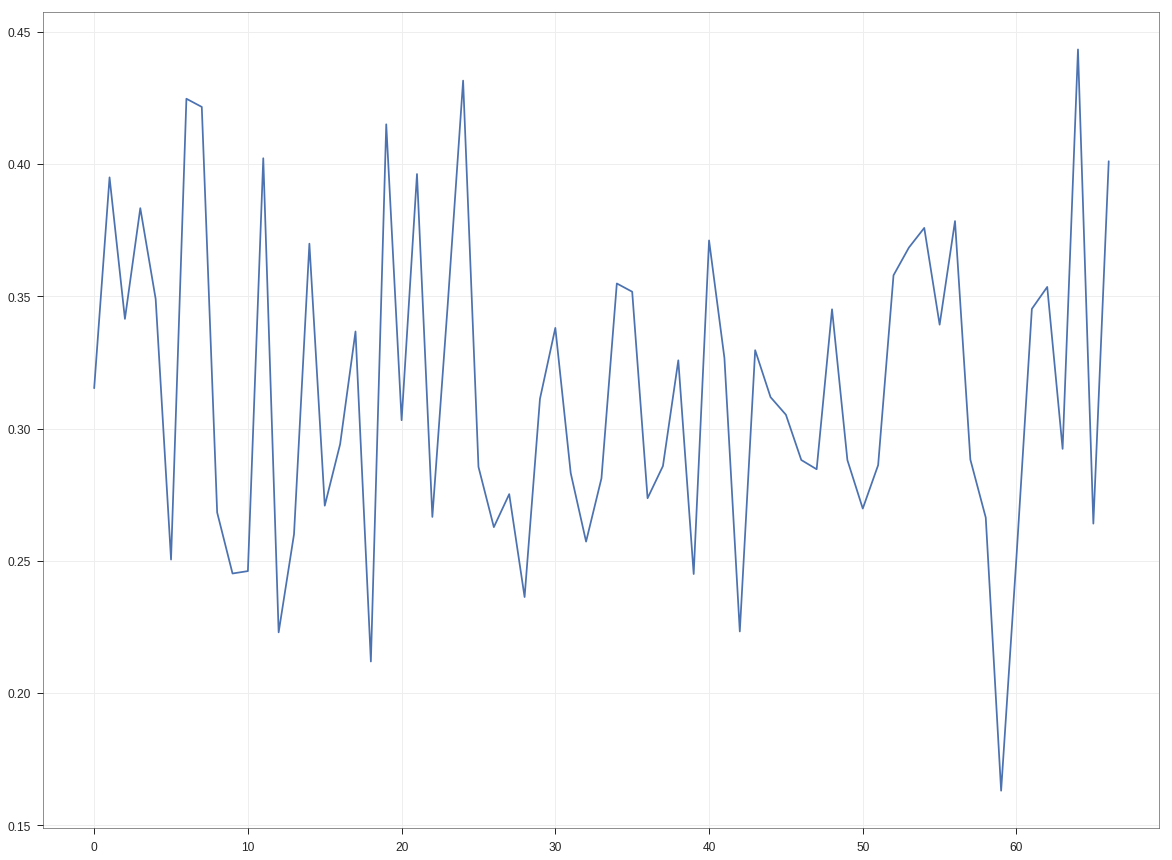

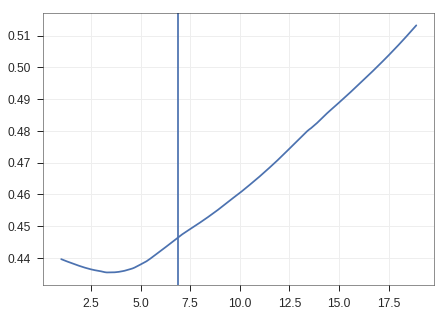

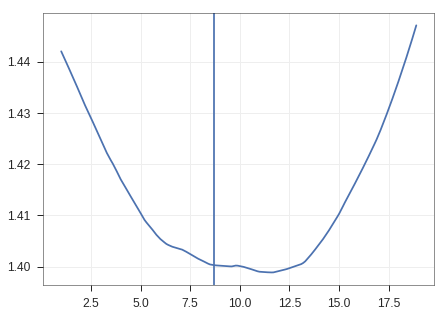

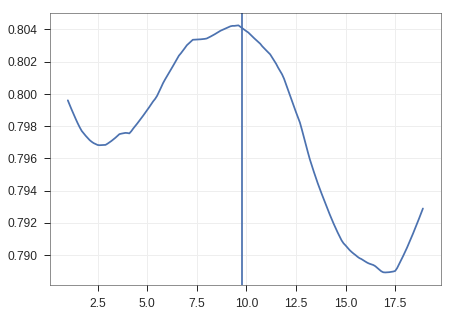

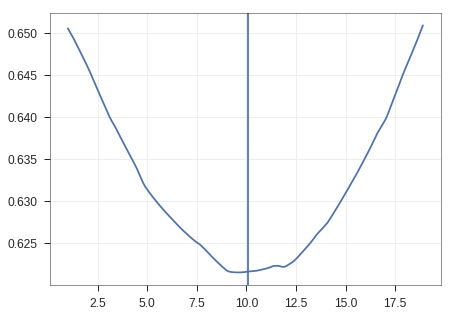

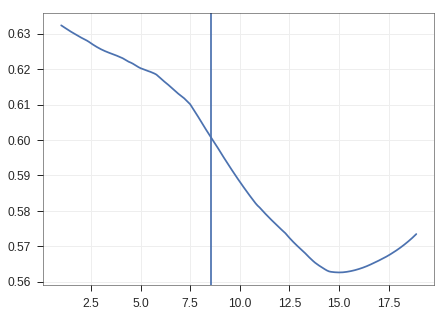

Epoch number:  33


In [ ]:
for epoch in range(epochs):
    
    print("Epoch number: ", epoch)
    
    losses = []
    
    # Training
    
    for X_batch, Y_batch, lengths, extra in tqdm_notebook(retrain_iterate_minibatches(train_smiles, old_smiles, 
                                                            train_features, old_features, 
                                                            batchsize, extra_loss), 
                                                           total=len(train_smiles)//batchsize):
        
        loss = model.train_step(X_batch, Y_batch, lengths, extra)
        losses.append(loss)
        
    
    model.save('tmp/other_{}_{}.chkpt'.format(100+epoch+5, np.mean(losses)))

    # Validation 
    
    aff_range = np.arange(1, 19, 0.1)
    
    if epoch < 5:
        indicies = full_indicies[:30]
    elif epoch < 20:
        indicies = full_indicies[:50]
    else:
        indiciescies = full_indicies
        

    trues, losses_others = [], []
    
    ## Generating new ones
    
    for smile, feat in tqdm_notebook(zip(*[test_smiles[indicies], test_features[indicies]])):
        _, los = measure_losses(smile, feat, aff_range)
        losses_others.append(los)
        trues.append(feat[-1])
        
    validation_losses.append(losses_others)
    global_trues.append(trues)
    
    
    clear_output(True)
    
    ## Vizualize training process
               
    print("Epoch loss: ", np.mean(losses))
    
    plt.figure(figsize=[20, 15])
    plt.plot(losses)
    
    for i in np.random.choice(np.arange(len(losses_others)), 5):
        plt.figure(figsize=[7, 5])
        draw_affinity_graph(aff_range, losses_others[i], trues[i])

    
    plt.show()

    averages.append(np.mean(losses))

# More validation

In [45]:
from scipy import stats

In [27]:
aff_range = np.arange(1, 19, 0.1)

indicies = np.random.choice(np.arange(len(test_features)), 100)

trues, losses = [], []

for smile, feat in tqdm_notebook(zip(*[test_smiles[indicies], test_features[indicies]])):
    tr, los = measure_losses(smile, feat, aff_range)
    trues.append(tr)
    losses.append(los)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [43]:
def score_epoch(losses, trues):
    
    affinities = np.arange(1, 19, 0.1)
    
    scores = []
    
    for loss, true in zip(losses, trues):
        lowest = np.min(loss)
        highest = np.max(loss)
        
        closest_pos = sorted(np.argsort(affinities - true)[:2])
        true_loss = np.mean(np.array(loss)[closest_pos])
        
        difference = np.abs(true_loss - lowest)
        
        scores.append(difference)
    
    final_score = stats.trim_mean(scores, 0.2)
    
    return final_score, scores

In [47]:
scores = [score_epoch(x, y)[0] for x, y in zip(validation_losses, global_trues)]

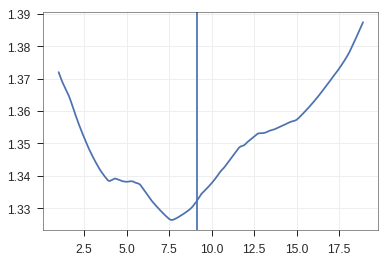

In [82]:
draw_affinity_graph(np.arange(1, 19, 0.1), validation_losses[102][0], global_trues[102][0])

In [ ]:
high = [score_epoch(x, y)[1] for x, y in zip(validation_losses, global_trues)]

In [143]:
high = [np.mean(x) for x in [stats.iqr(y) for y in validation_losses]]

In [135]:
len(validation_losses)

105

In [75]:
np.argmin(scores)

102

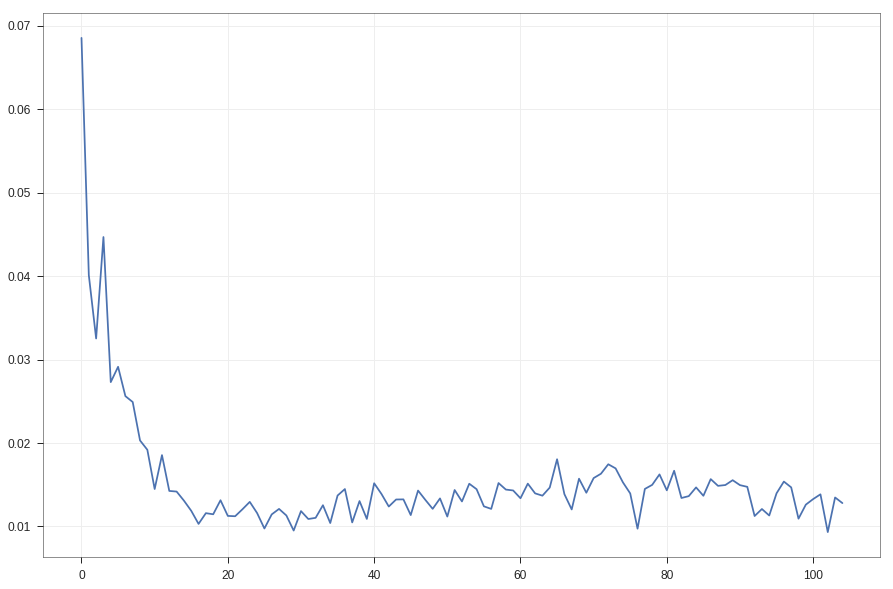

In [149]:
plt.figure(figsize=[15, 10])
plt.plot(scores)

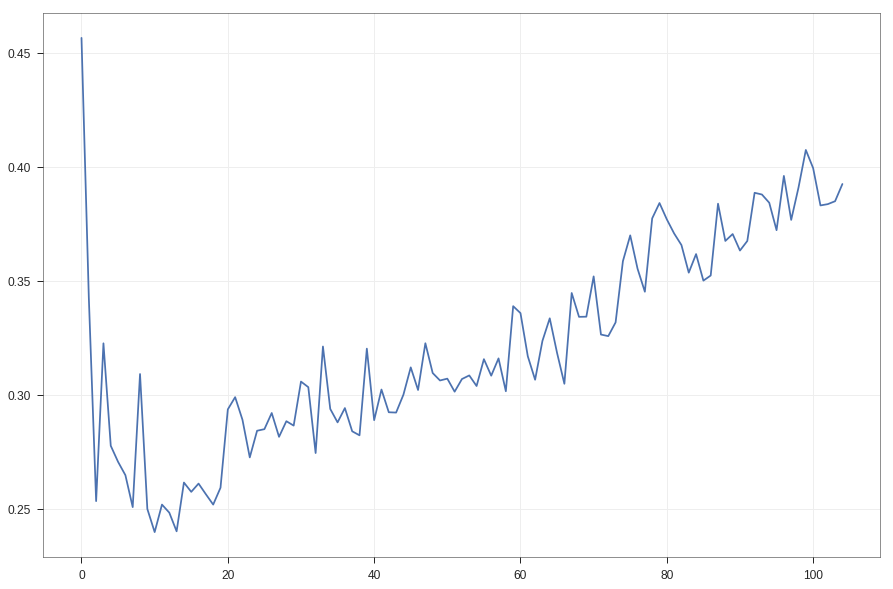

In [147]:
plt.figure(figsize=[15, 10])
plt.plot(high)

In [60]:
model.save('good_enough.chkpt')

# Generate new data

In [61]:
generated = []

In [62]:
gen_features = test_features.copy()

In [66]:
for feature in tqdm_notebook(gen_features[:700]):
    while True:
        new = generate_new(model, feature, True)
        if Chem.MolFromSmiles(new) is not None:
            generated.append(new)
            break

In [73]:
test_features.dump('test_features.npy')

In [70]:
with open('generated.res', 'w+') as f:
    for sm in generated:
        f.write(sm+'\n')